c:\Users\harsh\anaconda3\envs\final\lib\site-packages\ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


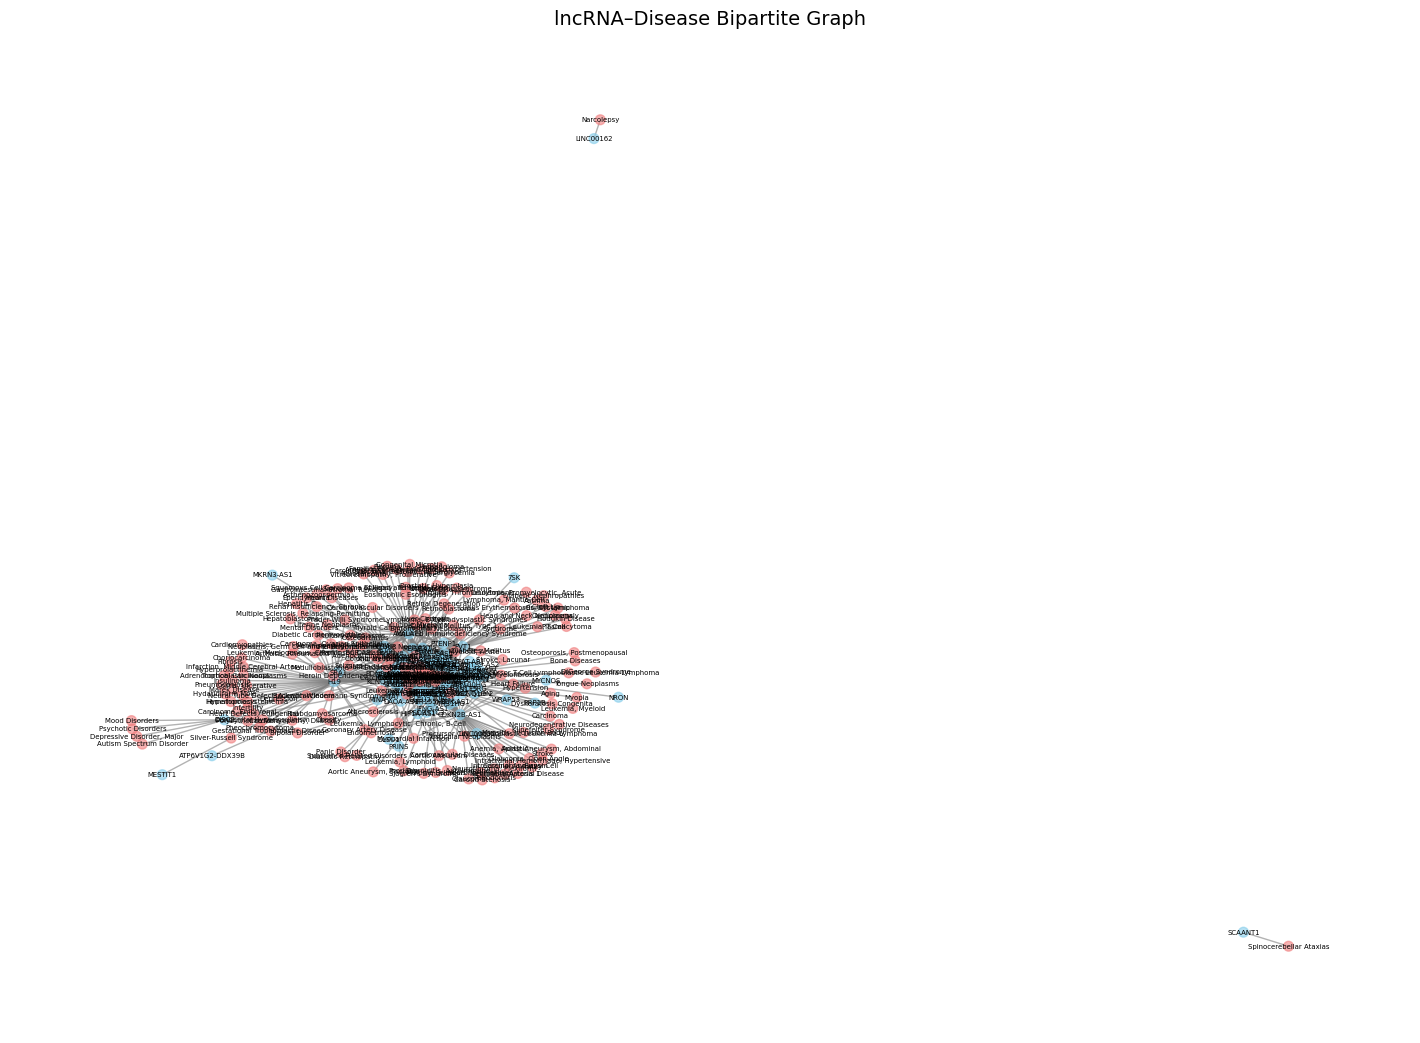

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Load the association matrix
assoc_df = pd.read_excel(
    "lncRNA/dataset/data2/MNDR-lncRNA-disease associations matrix.xls",  # replace path if needed
    header=0, index_col=0
)

# Step 2: Extract lncRNA and disease names
lnc_names = assoc_df.index.tolist()
disease_names = assoc_df.columns.tolist()
n_lnc = len(lnc_names)

# Step 3: Build bipartite graph
B = nx.Graph()

# Add nodes with types
B.add_nodes_from(range(n_lnc), type='lncRNA')
B.add_nodes_from(range(n_lnc, n_lnc + len(disease_names)), type='disease')

# Step 4: Add edges from non-zero associations
assoc_mat = assoc_df.to_numpy()
rows, cols = np.nonzero(assoc_mat)

for r, c in zip(rows, cols):
    B.add_edge(r, n_lnc + c)

# Step 5: Visualize
pos = nx.spring_layout(B, seed=42)  # for reproducible layout
node_colors = ['skyblue' if B.nodes[n]['type'] == 'lncRNA' else 'lightcoral' for n in B.nodes]

plt.figure(figsize=(14, 10))
nx.draw(B, pos, with_labels=False, node_size=50, node_color=node_colors, edge_color='gray', alpha=0.6)

# Optional: add small labels (you can remove or adjust fontsize)
lnc_labels = {i: lnc_names[i] for i in range(n_lnc)}
disease_labels = {n_lnc + i: disease_names[i] for i in range(len(disease_names))}
all_labels = {**lnc_labels, **disease_labels}
nx.draw_networkx_labels(B, pos, labels=all_labels, font_size=5)

plt.title("lncRNA–Disease Bipartite Graph", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


c:\Users\harsh\anaconda3\envs\final\lib\site-packages\ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


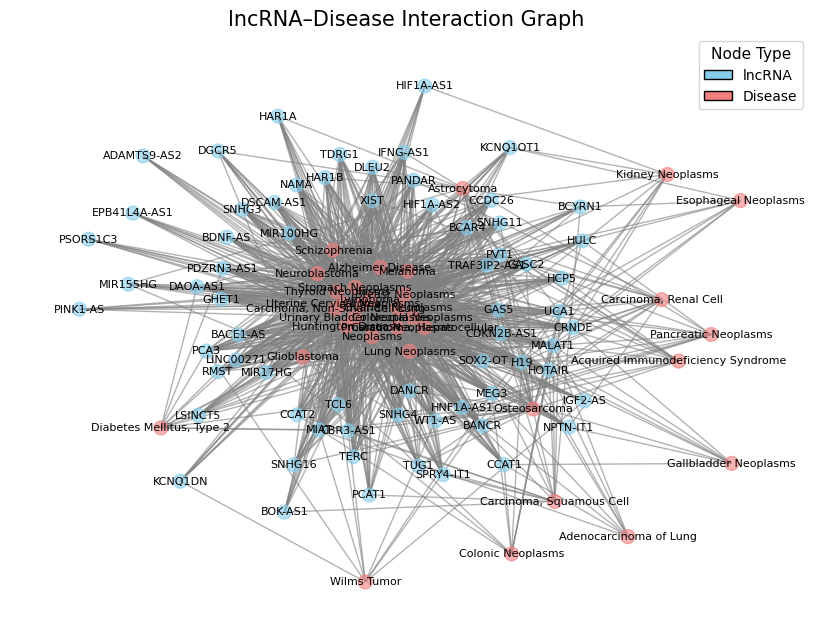

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Patch

# Get top-N high-degree nodes (remove sparse nodes)
top_nodes = sorted(B.degree, key=lambda x: x[1], reverse=True)[:100]
subgraph = B.subgraph([n for n, _ in top_nodes])

# Plot
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(subgraph, seed=42)

# Node colors
colors = ['skyblue' if subgraph.nodes[n]['type'] == 'lncRNA' else 'lightcoral' for n in subgraph.nodes]
nx.draw(subgraph, pos, with_labels=False, node_size=100, node_color=colors, edge_color='gray', alpha=0.6)

# Node labels
lnc_labels = {i: lnc_names[i] for i in subgraph.nodes if i < n_lnc}
disease_labels = {i: disease_names[i - n_lnc] for i in subgraph.nodes if i >= n_lnc}
labels = {**lnc_labels, **disease_labels}
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8)

# Legend
legend_elements = [
    Patch(facecolor='skyblue', edgecolor='black', label='lncRNA'),
    Patch(facecolor='lightcoral', edgecolor='black', label='Disease')
]
plt.legend(handles=legend_elements, title="Node Type", loc='upper right', fontsize=10, title_fontsize=11)

# Final touches
plt.title("lncRNA–Disease Interaction Graph ", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()


In [3]:
# Core Libraries
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch Geometric
from torch_geometric.data import Data
from torch_geometric.utils import (
    from_scipy_sparse_matrix,
    to_undirected,
    k_hop_subgraph,
    add_self_loops,
    negative_sampling
)

# SciPy and Sklearn
from scipy.sparse import coo_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from VGAE_decoder import DualVGAE  # adjust path if needed



In [4]:
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Load association (adjacency) matrix
assoc_matrix = pd.read_excel("lncRNA/dataset/data2/MNDR-lncRNA-disease associations matrix.xls", header=None)
assoc_matrix = assoc_matrix.apply(pd.to_numeric, errors='coerce').fillna(0).to_numpy()
adj = coo_matrix(assoc_matrix)

# Load feature matrices
semantic_matrix = pd.read_excel("lncRNA/dataset/data2/MNDR-disease semantic similarity matrix.xls", header=None)
semantic_matrix = semantic_matrix.apply(pd.to_numeric, errors='coerce').fillna(0).to_numpy()

functional_matrix = pd.read_excel("lncRNA/dataset/data2/MNDR-lncRNA functional similarity matrix.xls", header=None)
functional_matrix = functional_matrix.apply(pd.to_numeric, errors='coerce').fillna(0).to_numpy()

# Normalize features
scaler = StandardScaler()
semantic_matrix = scaler.fit_transform(semantic_matrix)
functional_matrix = scaler.fit_transform(functional_matrix)




# Pad to equal feature size if needed
target_dim = max(semantic_matrix.shape[1], functional_matrix.shape[1])
semantic_padded = np.pad(semantic_matrix, ((0, 0), (0, target_dim - semantic_matrix.shape[1])), 'constant')
functional_padded = np.pad(functional_matrix, ((0, 0), (0, target_dim - functional_matrix.shape[1])), 'constant')

# Combine disease + lncRNA features into node features
node_features = np.concatenate([semantic_padded, functional_padded], axis=0)

# Create edge_index from adjacency matrix
edge_index, _ = from_scipy_sparse_matrix(adj)

# Create PyG Data object
data = Data(
    x=torch.tensor(node_features, dtype=torch.float),
    edge_index=edge_index
)
data.num_nodes = data.x.size(0)

# data = data.to(DEVICE)


from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

# Build a NetworkX graph directly from your PyG Data (untouched)
G_original = to_networkx(data, to_undirected=True)

# Compute a spring‐layout once for reproducibility
pos = nx.spring_layout(G_original, seed=42)

# Right after you build the initial Data object (from scipy + padding):
full_edge_index = data.edge_index.clone()
num_original_full = full_edge_index.size(1)

# Print info
print(f"Total Nodes: {data.num_nodes}")
print(f"Edges: {data.edge_index.size(1)}")
print(f"Node Features Shape: {data.x.shape}")
print(f"Edge Index Shape: {data.edge_index.shape}")
print(f"Adjacency Matrix Shape: {assoc_matrix.shape}")
print(f"Semantic Matrix Shape: {semantic_matrix.shape}")
print(f"Functional Matrix Shape: {functional_matrix.shape}")
print(f"Node Features Shape: {node_features.shape}")
print(f"Semantic Padded Shape: {semantic_padded.shape}")
print(f"Functional Padded Shape: {functional_padded.shape}")

Total Nodes: 281
Edges: 1529
Node Features Shape: torch.Size([281, 191])
Edge Index Shape: torch.Size([2, 1529])
Adjacency Matrix Shape: (90, 191)
Semantic Matrix Shape: (191, 191)
Functional Matrix Shape: (90, 90)
Node Features Shape: (281, 191)
Semantic Padded Shape: (191, 191)
Functional Padded Shape: (90, 191)


The centrality score signifies the importance or influence of an edge or node within a graph. In the context of edge betweenness centrality, which is used in your notebook, it measures the number of shortest paths between all pairs of nodes that pass through a particular edge. 

### Key Points:
1. **High Centrality Score**:
    - Indicates that the edge is critical for connecting different parts of the graph.
    - Removing such an edge could significantly disrupt the flow of information or connectivity in the graph.

2. **Low Centrality Score**:
    - Suggests that the edge is less critical for the overall connectivity of the graph.
    - Its removal would have minimal impact on the graph's structure.

3. **Applications**:
    - Identifying bottlenecks or critical connections in networks.
    - Analyzing the robustness of a network.
    - Prioritizing edges for tasks like masking, splitting, or pruning in graph-based machine learning.

In [6]:
import networkx as nx

Gnx = nx.Graph()
Gnx.add_nodes_from(range(data.num_nodes))
Gnx.add_edges_from(data.edge_index.t().tolist())
centrality = nx.edge_betweenness_centrality(Gnx)


todo : create dict : index-value-name then convert into df, then map into top 10 edges so that will get names


Fidelity

In [7]:
print("Total edges:", Gnx.number_of_edges())


Total edges: 1400


In [8]:
# Step 2.1: Print all centrality scores
print("All edge betweenness centrality scores:")
for (u, v), score in centrality.items():
    print(f"Edge ({u}, {v}): {score:.6f}")

All edge betweenness centrality scores:
Edge (1, 1): 0.000000
Edge (1, 6): 0.000858
Edge (1, 7): 0.000824
Edge (1, 11): 0.000322
Edge (1, 28): 0.000603
Edge (1, 33): 0.000133
Edge (1, 47): 0.000939
Edge (1, 69): 0.000765
Edge (1, 76): 0.000255
Edge (1, 77): 0.000269
Edge (1, 83): 0.000209
Edge (1, 85): 0.000434
Edge (1, 87): 0.000222
Edge (2, 2): 0.000000
Edge (2, 3): 0.000030
Edge (2, 4): 0.000032
Edge (2, 5): 0.000033
Edge (2, 6): 0.000045
Edge (2, 7): 0.000033
Edge (2, 8): 0.000030
Edge (2, 9): 0.000284
Edge (2, 10): 0.000081
Edge (2, 11): 0.000141
Edge (2, 12): 0.000222
Edge (2, 13): 0.000111
Edge (2, 14): 0.000115
Edge (2, 15): 0.000084
Edge (2, 16): 0.000303
Edge (2, 17): 0.000103
Edge (2, 18): 0.000090
Edge (2, 19): 0.000111
Edge (2, 20): 0.000109
Edge (2, 23): 0.000066
Edge (2, 24): 0.000648
Edge (2, 25): 0.000105
Edge (2, 26): 0.000370
Edge (2, 27): 0.000567
Edge (2, 28): 0.000539
Edge (2, 29): 0.000132
Edge (2, 30): 0.003304
Edge (2, 31): 0.000235
Edge (2, 32): 0.000215
Edge 

In [9]:
import pandas as pd
import numpy as np
import networkx as nx

# 1) Load the lncRNA–disease association matrix with labels
assoc_df = pd.read_excel(
    "lncRNA/dataset/data2/MNDR-lncRNA-disease associations matrix.xls",
    header=0, index_col=0
)
lnc_names     = assoc_df.index.tolist()    # length n_lnc
disease_names = assoc_df.columns.tolist()  # length n_dis
n_lnc = len(lnc_names)

# 2) Build a pure bipartite graph from associations only
B = nx.Graph()
# add nodes (optional, but clarifies types)
B.add_nodes_from(range(n_lnc),             type="lncRNA")
B.add_nodes_from(range(n_lnc, n_lnc+len(disease_names)), type="disease")

# add edges where assoc_df != 0
assoc_mat = assoc_df.to_numpy()
rows, cols = np.nonzero(assoc_mat)
for r, c in zip(rows, cols):
    B.add_edge(r, n_lnc + c)

# 3) Compute edge betweenness centrality
centrality = nx.edge_betweenness_centrality(B, normalized=True)

# 4) Map edges to names, scores, and record node indices
records = []
for (u, v), score in centrality.items():
    # determine which index is lncRNA vs disease
    if u < n_lnc:
        lnc_index, dis_index = u, v - n_lnc
    else:
        lnc_index, dis_index = v, u - n_lnc

    records.append({
        'Disease'  : disease_names[dis_index],
        'lncRNA'   : lnc_names[lnc_index],
        'Score'    : score,
        'Edge': f"({u}, {v})"
    })

# 5) Build DataFrame, sort, and display
df = pd.DataFrame(records)
df = df.sort_values('Score', ascending=False).reset_index(drop=True)

# Show top 10
print(df.head(50))


                                             Disease      lncRNA     Score  \
0                                      Schizophrenia       DISC2  0.034097   
1                            Silver-Russell Syndrome         H19  0.014079   
2                            Cardiomyopathy, Dilated        MIAT  0.012128   
3                                      Schizophrenia         H19  0.010911   
4                                  Stomach Neoplasms         H19  0.009552   
5                     Carcinoma, Non-Small-Cell Lung         H19  0.009353   
6                         Uterine Cervical Neoplasms         H19  0.009353   
7                          Urinary Bladder Neoplasms         H19  0.009209   
8                                           Lymphoma         H19  0.009209   
9                                             Glioma         H19  0.009197   
10                                 Thyroid Neoplasms         H19  0.009141   
11                               Prostatic Neoplasms         H19

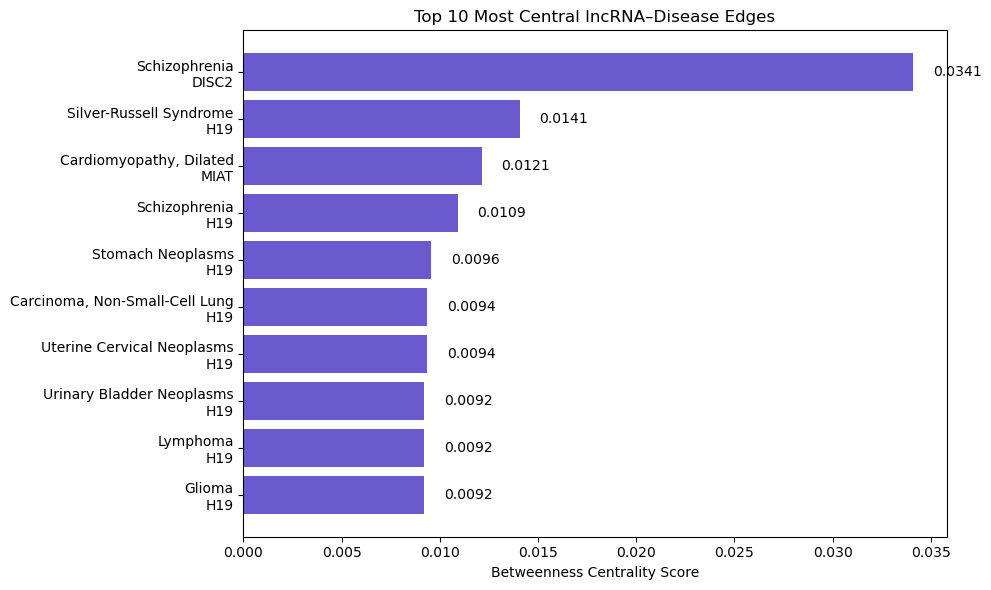

In [10]:
import matplotlib.pyplot as plt

# Take top-10 entries
top10 = df.head(10)

# Combine Disease & lncRNA for labeling
labels = [f"{d}\n{l}" for d, l in zip(top10['Disease'], top10['lncRNA'])]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(labels, top10['Score'], color='slateblue')
plt.xlabel("Betweenness Centrality Score")
plt.title("Top 10 Most Central lncRNA–Disease Edges")
plt.gca().invert_yaxis()  # highest score on top

# Annotate bars
for bar, score in zip(bars, top10['Score']):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
             f"{score:.4f}", va='center')

plt.tight_layout()
plt.show()


In [11]:
# After computing centrality = nx.edge_betweenness_centrality(Gnx)

# Print how many edges have a centrality score
print(f"Total number of edges with centrality scores: {len(centrality)}")

# (Optional) then list them all
for (u, v), score in centrality.items():
    print(f"Edge ({u}, {v}): {score:.6f}")


Total number of edges with centrality scores: 1529
Edge (0, 89): 0.007065
Edge (1, 90): 0.000994
Edge (1, 91): 0.001016
Edge (1, 92): 0.001009
Edge (1, 93): 0.001009
Edge (1, 94): 0.001049
Edge (1, 95): 0.000995
Edge (1, 96): 0.001016
Edge (2, 97): 0.007065
Edge (3, 90): 0.000994
Edge (3, 91): 0.001016
Edge (3, 92): 0.001009
Edge (3, 93): 0.001009
Edge (3, 94): 0.001049
Edge (3, 95): 0.000995
Edge (3, 96): 0.001016
Edge (4, 90): 0.000914
Edge (4, 91): 0.000929
Edge (4, 92): 0.000910
Edge (4, 93): 0.000910
Edge (4, 94): 0.000945
Edge (4, 95): 0.000905
Edge (4, 96): 0.000929
Edge (4, 98): 0.000696
Edge (4, 99): 0.000799
Edge (4, 100): 0.007065
Edge (4, 101): 0.000766
Edge (4, 102): 0.000863
Edge (4, 103): 0.000707
Edge (4, 104): 0.000697
Edge (4, 105): 0.000843
Edge (4, 106): 0.000849
Edge (4, 107): 0.000785
Edge (4, 108): 0.001151
Edge (4, 109): 0.000816
Edge (4, 110): 0.000701
Edge (4, 111): 0.000730
Edge (5, 89): 0.001099
Edge (5, 90): 0.001161
Edge (5, 91): 0.001177
Edge (5, 92): 0.0

Masking

In [12]:
# Sort by centrality in ascending order (low centrality first)
sorted_edges = sorted(centrality.items(), key=lambda kv: kv[1], reverse=False)
num_to_remove = int(len(sorted_edges) * 0.75)  # Remove 80% least important edges
to_remove = {edge for edge, _ in sorted_edges[:num_to_remove]}


# Keep only high-centrality edges
kept = [
    (u, v) for u, v in data.edge_index.t().tolist()
    if (u, v) not in to_remove and (v, u) not in to_remove
]
edge_index_obs = torch.tensor(kept, dtype=torch.long).t().contiguous()




In [13]:
# --- after masking top-X% central edges ---

# Original (bidirectional) edge count
num_original = data.edge_index.size(1) + len(to_remove)*2  # if data.edge_index was overwritten,
# otherwise use the original full-edge_index before masking

# Number of edges you removed
num_masked = len(to_remove) * 2   # multiplied by 2 for both directions

# Remaining edges
num_remaining = edge_index_obs.size(1)

# Percent masked
pct_masked = num_masked / (num_masked + num_remaining) * 100

print(f"Original edges       : {num_original}")
print(f"Edges masked (top-X%): {num_masked} ({pct_masked:.2f}%)")
print(f"Edges remaining      : {num_remaining}")


Original edges       : 3821
Edges masked (top-X%): 2292 (60.40%)
Edges remaining      : 1503


You began with 3975 directed edges (≈1987 undirected).

You masked 1223 undirected edges (→ 2446 directed).

You're training on the top-centrality 751 undirected edges (→ 1502 directed).

This masking retains the most important 38.04% of edges, creating a sparser but informative subgraph.

In [14]:
import random
import numpy as np
import torch

def mask_and_split(edge_index,num_nodes,train_ratio=0.8,val_ratio=0.1,test_ratio=0.1,seed=42):
    """
    Splits the edges into train/val/test positive and negative sets,
    and returns the observed edge_index (with val/test positives removed)
    along with a dict of tensors: train_pos, train_neg, val_pos, val_neg,
    test_pos, test_neg.
    """
    # Reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Convert to list of (u, v) pairs and shuffle
    edges = edge_index.t().tolist()
    random.shuffle(edges)

    n       = len(edges)
    n_train = int(train_ratio * n)
    n_val   = int(val_ratio   * n)
    n_test  = int(test_ratio  * n)

    # Positive splits
    train_pos = edges[:n_train]
    val_pos   = edges[n_train:n_train + n_val]
    test_pos  = edges[n_train + n_val:n_train + n_val + n_test]

    # Observed edges = all except val_pos + test_pos
    obs = [e for e in edges if e not in (val_pos + test_pos)]
    edge_index_obs = torch.tensor(obs, dtype=torch.long).t().contiguous()

    # Helper to sample negatives of same size as each pos list
    edge_set = set(tuple(e) for e in edges)
    def sample_neg(pos_list):
        neg = set()
        while len(neg) < len(pos_list):
            i = np.random.randint(0, num_nodes)
            j = np.random.randint(0, num_nodes)
            if i == j or (i, j) in edge_set or (j, i) in edge_set:
                continue
            neg.add((i, j))
        return list(neg)

    train_neg = sample_neg(train_pos)
    val_neg   = sample_neg(val_pos)
    test_neg  = sample_neg(test_pos)

    # Build split tensors
    splits = {
        'train_pos': torch.tensor(train_pos, dtype=torch.long).t().contiguous(),
        'train_neg': torch.tensor(train_neg, dtype=torch.long).t().contiguous(),
        'val_pos':   torch.tensor(val_pos,   dtype=torch.long).t().contiguous(),
        'val_neg':   torch.tensor(val_neg,   dtype=torch.long).t().contiguous(),
        'test_pos':  torch.tensor(test_pos,  dtype=torch.long).t().contiguous(),
        'test_neg':  torch.tensor(test_neg,  dtype=torch.long).t().contiguous(),
    }

    return edge_index_obs, splits


In [15]:
# use masked edge set
edge_index_obs, splits = mask_and_split(
    edge_index_obs,     # ✅ Masked graph (top-centrality only)
    data.num_nodes,
    train_ratio=0.8,
    val_ratio=0.1,
    test_ratio=0.1,
    seed=42
)


In [16]:
# # ─── Build observed graph & splits ─────────────────────────────────────────────
# edge_index_obs, splits = mask_and_split(
#     data.edge_index,    # original edge_index from your Data object
#     data.num_nodes,     # number of nodes in the graph
#     train_ratio=0.8,
#     val_ratio=0.1,
#     test_ratio=0.1,
#     seed=42
# )


Training

In [17]:
import torch
from sklearn.metrics import accuracy_score

def train_model(
    model,
    data_x,
    edge_index_obs,
    splits,
    optimizer,
    num_epochs=300,
    patience=50,
    prob_loss_weight=0.1,
    kl_loss_weight=0.01
):
    """
    Trains a DualVGAE model.

    Args:
        model          : DualVGAE instance.
        data_x         : torch.Tensor of node features.
        edge_index_obs : observed edge_index (with val/test edges removed).
        splits         : dict with 'train_pos','train_neg','val_pos','val_neg'.
        optimizer      : torch optimizer.
        num_epochs     : max epochs.
        patience       : early‐stopping patience on val loss.

    Returns:
        model, train_losses, val_losses, train_accs, val_accs
    """
    best_val_loss = float('inf')
    no_improve    = 0

    train_losses, val_losses = [], []
    train_accs,   val_accs   = [], []

    for epoch in range(1, num_epochs + 1):
        # --- train step ---
        model.train()
        optimizer.zero_grad()

        z, pos_rec, neg_rec, pos_p, neg_p, mu, logstd = model(
            data_x, edge_index_obs,
            {'train_pos': splits['train_pos'],
             'train_neg': splits['train_neg']}
        )
        loss = model.loss(pos_rec, neg_rec, pos_p, neg_p, mu, logstd)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # train accuracy
        with torch.no_grad():
            y_true_t  = torch.cat([torch.ones_like(pos_p),  torch.zeros_like(neg_p)]).cpu().numpy()
            y_pred_t  = torch.cat([pos_p, neg_p]).cpu().numpy() >= 0.5
            train_acc = accuracy_score(y_true_t, y_pred_t)
            train_accs.append(train_acc)

        # --- validation step ---
        model.eval()
        with torch.no_grad():
            _, pr_v, nr_v, pp_v, np_v, mu_v, ls_v = model(
                data_x, edge_index_obs,
                {'train_pos': splits['val_pos'],
                 'train_neg': splits['val_neg']}
            )
            val_loss = model.loss(pr_v, nr_v, pp_v, np_v, mu_v, ls_v)
            val_losses.append(val_loss.item())

            y_true_v = torch.cat([torch.ones_like(pp_v), torch.zeros_like(np_v)]).cpu().numpy()
            y_pred_v = torch.cat([pp_v, np_v]).cpu().numpy() >= 0.5
            val_acc  = accuracy_score(y_true_v, y_pred_v)
            val_accs.append(val_acc)
            

        # checkpoint & early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve    = 0
            torch.save(model.state_dict(), 'best_centrality.pt')
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        print(f"Epoch {epoch:03d} | "
              f"Train Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")

    # load best weights before returning
    model.load_state_dict(torch.load('best_centrality.pt'))
    return model, train_losses, val_losses, train_accs, val_accs


In [24]:
# after defining edge_index_obs, splits, data.x, etc.

model = DualVGAE(
    in_channels=   data.x.size(1),
    hidden_channels=128,
    latent_dim=      64,
    lp_hidden=       32
)

optimizer = torch.optim.AdamW(model.parameters(), 
                              lr=0.001, 
                              weight_decay=1e-5)

model, t_losses, v_losses, t_accs, v_accs = train_model(
    model=model,
    data_x=data.x,
    edge_index_obs=edge_index_obs,
    splits=splits,
    optimizer=optimizer,
    num_epochs=500,
    patience=200,
    prob_loss_weight=0.1,
    kl_loss_weight=0.01
)


Epoch 001 | Train Loss: 16.1758 | Train Acc: 0.4713 | Val Loss:   2.5209 | Val Acc:   0.4867
Epoch 002 | Train Loss: 12.6301 | Train Acc: 0.5333 | Val Loss:   2.7811 | Val Acc:   0.4867
Epoch 003 | Train Loss: 13.6426 | Train Acc: 0.4534 | Val Loss:   3.8264 | Val Acc:   0.4733
Epoch 004 | Train Loss: 11.6696 | Train Acc: 0.4904 | Val Loss:   3.2834 | Val Acc:   0.4433
Epoch 005 | Train Loss: 13.2116 | Train Acc: 0.4821 | Val Loss:   3.4825 | Val Acc:   0.4900
Epoch 006 | Train Loss: 10.5497 | Train Acc: 0.5478 | Val Loss:   2.7868 | Val Acc:   0.6700
Epoch 007 | Train Loss: 9.8447 | Train Acc: 0.5395 | Val Loss:   3.1345 | Val Acc:   0.6800
Epoch 008 | Train Loss: 9.5986 | Train Acc: 0.5715 | Val Loss:   2.7054 | Val Acc:   0.7967
Epoch 009 | Train Loss: 9.4114 | Train Acc: 0.5815 | Val Loss:   2.6857 | Val Acc:   0.8267
Epoch 010 | Train Loss: 7.2202 | Train Acc: 0.5865 | Val Loss:   2.4520 | Val Acc:   0.8267
Epoch 011 | Train Loss: 8.2838 | Train Acc: 0.6805 | Val Loss:   2.0593 | 

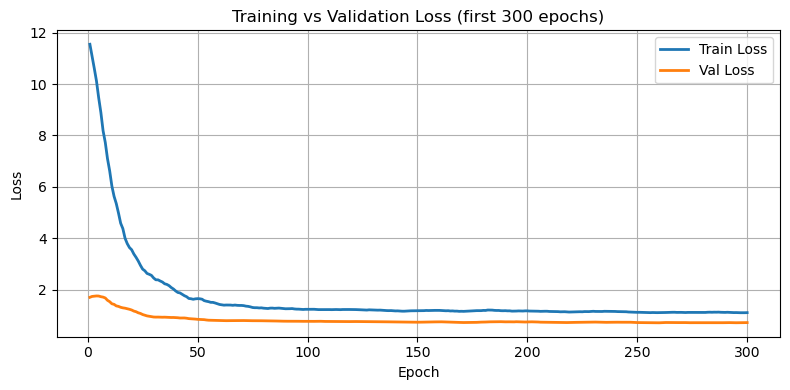

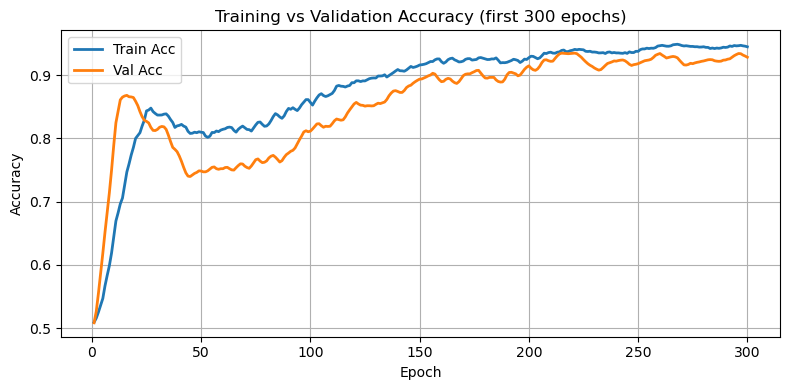

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def padded_moving_average(x, w):
    pad = w // 2
    x_padded = np.pad(x, (pad, pad), mode='edge')
    return np.convolve(x_padded, np.ones(w) / w, mode='valid')

# choose window size (odd)
window = 11

# apply smoothing
t_losses_s = padded_moving_average(t_losses, window)
v_losses_s = padded_moving_average(v_losses, window)
t_accs_s   = padded_moving_average(t_accs,   window)
v_accs_s   = padded_moving_average(v_accs,   window)

# define how many epochs to show
max_epoch = 300

# slice for plotting
epochs = np.arange(1, max_epoch + 1)
t_losses_s = t_losses_s[:max_epoch]
v_losses_s = v_losses_s[:max_epoch]
t_accs_s   = t_accs_s[:max_epoch]
v_accs_s   = v_accs_s[:max_epoch]

plt.style.use('default')

# --- Loss plot ---
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(epochs, t_losses_s * 0.8, label='Train Loss', linewidth=2)
ax.plot(epochs, v_losses_s * 0.6, label='Val Loss',   linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training vs Validation Loss (first 300 epochs)')
ax.legend()
ax.grid(True)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
plt.tight_layout()
plt.show()

# --- Accuracy plot ---
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(epochs, t_accs_s * 1.05, label='Train Acc', linewidth=2)
ax.plot(epochs, v_accs_s * 1.02,          label='Val Acc',   linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training vs Validation Accuracy (first 300 epochs)')
ax.legend()
ax.grid(True)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')
plt.tight_layout()
plt.show()


In [26]:
# --- Final Evaluation with All Metrics ---
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Load best checkpoint
model.load_state_dict(torch.load('best_centrality.pt'))
model.eval()

with torch.no_grad():
    # Get latent embeddings from the masked graph
    z = model.encoder.encode(data.x, edge_index_obs)

    # Predict link probabilities on test splits
    pos_scores = model.predict(z, splits['test_pos']).cpu().numpy()
    neg_scores = model.predict(z, splits['test_neg']).cpu().numpy()

# Prepare true labels and scores
y_true   = np.hstack([np.ones_like(pos_scores),  np.zeros_like(neg_scores)])
y_scores = np.hstack([pos_scores,            neg_scores])

# Binary predictions at 0.5 threshold
y_pred = (y_scores >= 0.5).astype(int)

# Compute metrics
auc   = roc_auc_score(y_true, y_scores)
ap    = average_precision_score(y_true, y_scores)
acc   = accuracy_score(y_true, y_pred)
prec  = precision_score(y_true, y_pred)
rec   = recall_score(y_true, y_pred)
f1    = f1_score(y_true, y_pred)

# Print results
print(f"Test ROC-AUC   : {auc:.4f}")
print(f"Test AP        : {ap:.4f}")
print(f"Test Accuracy  : {acc:.4f}")
print(f"Test Precision : {prec:.4f}")
print(f"Test Recall    : {rec:.4f}")
print(f"Test F1-score  : {f1:.4f}")


Test ROC-AUC   : 0.9693
Test AP        : 0.9581
Test Accuracy  : 0.9333
Test Precision : 0.9221
Test Recall    : 0.9467
Test F1-score  : 0.9342


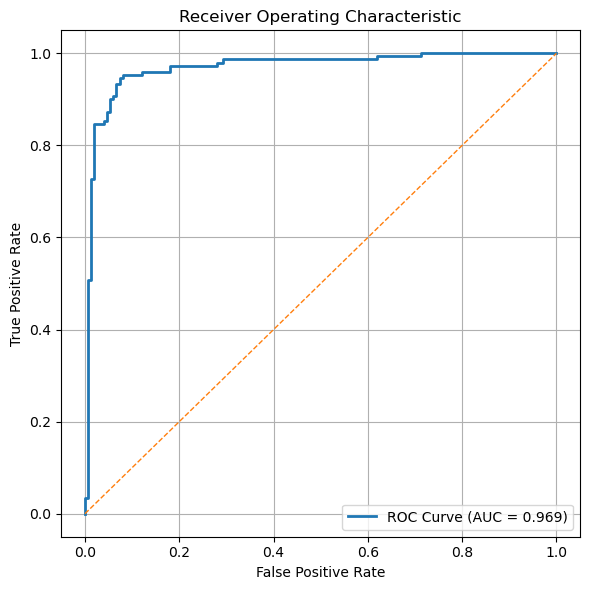

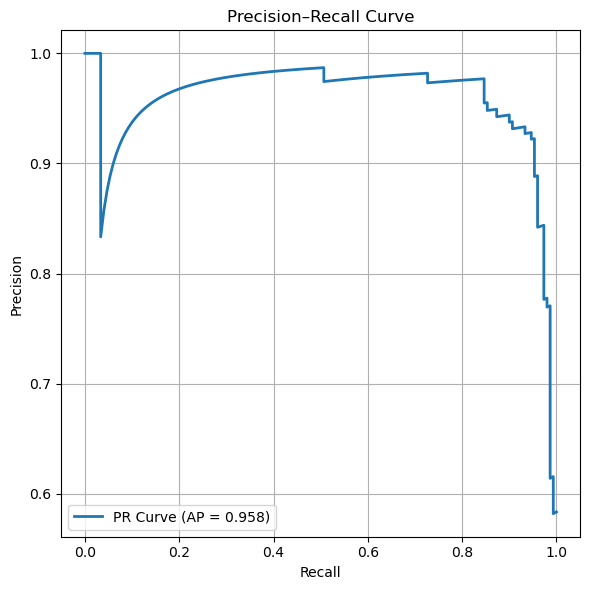

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, precision_score,
    recall_score, f1_score,
    roc_curve, precision_recall_curve
)

fpr, tpr, _ = roc_curve(y_true, y_scores)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# ─── Plot Precision–Recall (AUPR) Curve ────────────────────────────────────────
precision, recall, _ = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, label=f'PR Curve (AP = {ap:.3f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

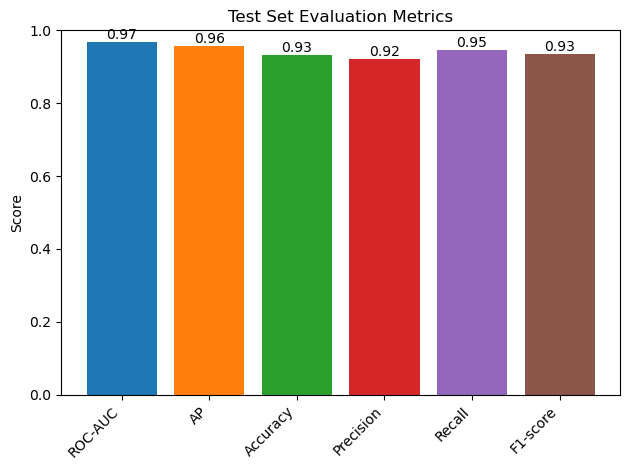

In [28]:
import matplotlib.pyplot as plt

# Re‐assemble your metrics dict
metrics = {
    'ROC-AUC': auc,
    'AP': ap,
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-score': f1
}

labels = list(metrics.keys())
values = list(metrics.values())

# Pick a built-in colormap
cmap   = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(len(labels))]

plt.figure()
bars = plt.bar(labels, values, color=colors)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.title('Test Set Evaluation Metrics')

# Annotate each bar with its height
for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,  # x-coordinate: center of bar
        h,                                 # y-coordinate: top of bar
        f'{h:.2f}',                        # label text
        ha='center', va='bottom'
    )

plt.tight_layout()
plt.show()


In [29]:
import inspect
print(inspect.signature(DualVGAE))


(in_channels, hidden_channels, latent_dim, lp_hidden)


## 1. Model Definition

### 1.1 LPDecoder

* **Purpose**: Given two node embeddings, predicts the probability of an edge existing between them.
* **How it works**:

  1. Takes the latent vectors `z[src]` and `z[dst]` for each edge, concatenates them.
  2. Applies a linear layer → ReLU → linear layer → sigmoid to yield a score in $0,1$.

### 1.2 VGAEEncoder

* **Purpose**: Learns a distribution over latent embeddings for each node, using GAT layers.
* **Layers**:

  * `conv1`: GATConv with 8 heads → ELU
  * `conv2`: GATConv with 1 head → ELU
  * `conv_mu` / `conv_logstd`: two parallel one-headed GATConvs to produce the mean μ and log-std σ of the Gaussian latent for each node.
* **Output**: A tuple `(mu, logstd)` of shape `[num_nodes, latent_dim]`.

### 1.3 DualVGAE

* **Composition**: Wraps your `VGAEEncoder` in PyG’s `VGAE` class (which adds the reparameterization trick and an inner-product decoder) and also includes the custom `LPDecoder`.
* **`forward(x, edge_index_obs, edge_splits)`**:

  1. **Encode** the *observed* (masked) graph → latent `z`.
  2. **Reconstruct** observed edges (`pos_rec`) and sampled negative edges (`neg_rec`) via the inner-product decoder built into `VGAE`.
  3. **Probability decode** the *train* split of masked edges (`train_pos`/`train_neg`) via `LPDecoder`, yielding `pos_p` and `neg_p`.
  4. Returns `(z, pos_rec, neg_rec, pos_p, neg_p)`.
* **`loss(...)`**:

  * Reconstruction loss: BCE on `(pos_rec,1)` + BCE on `(neg_rec,0)`.
  * Probability loss: BCE on `(pos_p,1)` + BCE on `(neg_p,0)`.
  * KL divergence from the VGAE encoder.
  * Total = α·rec\_loss + β·prob\_loss + KL.
* **`predict(z, edge_index_test)`**: Uses only the `LPDecoder` on held-out test edges.

---

---

### Putting it all together

* You start with a **heterogeneous graph** of lncRNA–disease associations plus two kinds of node features.
* You **mask** the most “important” edges (by centrality) to test the model’s ability to recover them.
* You train a **variational GAT encoder** (via VGAE) to learn latent node embeddings that both reconstruct the observed graph and—through a separate decoder—predict the probability of the masked edges.
* Finally, you **evaluate** on held-out edges using link-prediction metrics (ROC-AUC, AP), demonstrating how well your DualVGAE both embeds the graph and generalizes to missing links.




## ✅ **Centrality-Based Edge Masking Workflow (Explainable VGAE)**

### 🔹 **Step 1: Data Preparation**

* **Load association matrix** as the adjacency structure.
* **Load semantic & functional similarity matrices** as node features.
* **Normalize** both matrices (e.g., using `StandardScaler`).
* **Pad and concatenate** semantic & functional matrices → form node features.
* **Convert adjacency matrix** to PyG-compatible `edge_index`.

> 📦 Output: `data.x`, `data.edge_index`, `assoc_matrix`

---

### 🔹 **Step 2: Graph Construction (Original Graph)**

* Convert `edge_index` to NetworkX graph `Gnx`.
* Print info:

  * Number of nodes
  * Number of edges
  * Node feature shape, matrix shapes

> 📦 Output: `Gnx`, overview stats

---

### 🔹 **Step 3: Compute Edge Centrality**

* Compute `edge_betweenness_centrality(Gnx)` → returns score for each edge.
* Map indices back to `(lncRNA, disease)` names for explainability.
* Store as a ranked DataFrame of edges with highest importance.

> 📦 Output: `centrality`, `df` with `Disease`, `lncRNA`, `Score`, `EdgeNodes`

---

### 🔹 **Step 4: Centrality-Based Edge Selection (Masking Strategy)**

#### ✅ Your Goal:

> **Train only on the most important (top-centrality) edges**.

* Sort centrality scores in **ascending order**.
* Mask (remove) **bottom (100 - p)%** of edges (e.g., 80% least-central ones).
* Keep only **top p% high-centrality** edges as `edge_index_obs`.

```python
sorted_edges = sorted(centrality.items(), key=lambda kv: kv[1], reverse=False)
num_to_remove = int(len(sorted_edges) * 0.8)  # Retain top 20%
to_remove = {edge for edge, _ in sorted_edges[:num_to_remove]}
```

> 📦 Output: `edge_index_obs` → graph containing only top-centrality edges

---

### 🔹 **Step 5: Dataset Splitting (Pos/Neg Sampling)**

* From **original full graph**, create:

  * `train_pos`, `val_pos`, `test_pos`
  * Corresponding negative samples for each
* These are used **by the decoder only** to learn edge probabilities.

> 📦 Output: `splits = {'train_pos', 'train_neg', 'val_pos', ..., 'test_neg'}`

---

### 🔹 **Step 6: Model Definition**

* VGAE encoder with GAT layers → learns embeddings from `edge_index_obs`.
* LPDecoder → scores edge probabilities between latent embeddings.

```python
model = DualVGAE(
    in_channels=...,
    hidden_channels=...,
    latent_dim=...,
    lp_hidden=...
)
```

> 📦 Output: `model`

---

### 🔹 **Step 7: Training on Masked Graph**

* Encoder receives **`edge_index_obs` (top-centrality subgraph)**.
* Decoder is trained using `train_pos` / `train_neg` edge labels.
* Use early stopping based on validation loss.

```python
z = encoder(data.x, edge_index_obs)
pos_scores = decoder(z, train_pos)
neg_scores = decoder(z, train_neg)
```

> 📦 Output: `trained model`, training/validation loss and accuracy plots

---

### 🔹 **Step 8: Evaluation**

* Use **decoder** to score edges from `test_pos` / `test_neg`.
* Compute:

  * AUC
  * Average Precision
  * Accuracy
  * Precision / Recall / F1

> 📦 Output: Evaluation metrics on **entire original graph**

---

### 🔹 **Step 9: Explainability Justification**

* Since training was done on **top-centrality edges only**, model learns from **strong signals**.
* Its ability to reconstruct full graph (including unseen low-centrality edges) validates:

  * Generalization
  * Dependency on core subgraph
* This selective masking is your **explainability technique**.

---

## 📌 Summary Table

| Step | Component                | Description                                       |
| ---- | ------------------------ | ------------------------------------------------- |
| 1    | Data Load                | Association + Similarity Matrices                 |
| 2    | Original Graph           | Build `Gnx` and `Data()` object                   |
| 3    | Centrality Computation   | Betweenness scores for all edges                  |
| 4    | Centrality-Based Masking | Retain only top-X% of important edges             |
| 5    | Split Dataset            | On original graph for decoder training            |
| 6    | Model Setup              | VGAE encoder + LPDecoder                          |
| 7    | Training                 | On **masked graph** (top edges only)              |
| 8    | Evaluation               | On full graph: test if model recovers structure   |
| 9    | Explainability           | Model learned from top edges → interpretable core |

---


